#MSCFE 610 Financial Econometrics

##Group Work Project 2 - Student Group: 12188
## Group Members: DAVID OLUTUNDE DANIEL, NAJD FARIS A ALEID, PRATYUSH MATHUR

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.3/503.3 kB 10.6 MB/s eta 0:00:00
CHALLENGE 1: AAPL-SPY COINTEGRATION


/tmp/ipython-input-3576649382.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl_data = yf.download('AAPL', start='2018-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3576649382.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sppy_data = yf.download('SPY', start='2018-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed



1. Stationarity Tests:
AAPL Price: ADF=0.0830, p=0.9649
SPY Price: ADF=0.3174, p=0.9781
AAPL Returns: ADF=-13.2386, p=0.0000
SPY Returns: ADF=-12.9227, p=0.0000

2. Cointegration Test (Engle-Granger):
Cointegration test: statistic=-2.4125, p=0.3190

3. Error Correction Model:
ECM Results:
  ΔSPY coefficient: 0.409
  Error correction: -0.006
  R-squared: 0.527
  Half-life: 113 days

CHALLENGE 2: REGIME CHANGE DETECTION


/tmp/ipython-input-3576649382.py:91: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2018-01-01', end='2024-12-31')['Close'].squeeze()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3576649382.py:153: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_full = yf.download('BTC-USD', start='2020-01-01', end='2023-12-31')


S&P 500 Returns (2018-2024):
  Observations: 1759
  Mean: 0.0524%
  Volatility: 1.2427%

Regime Statistics:
Low Vol Regime: 1334 days
  Mean: 0.0421%, Vol: 0.9110%
High Vol Regime: 425 days
  Mean: 0.0844%, Vol: 1.9474%

Markov Switching Model (2-state):
State 0 (Low Vol): Volatility = 1.0420%
State 1 (High Vol): Volatility = 1.2009%

Transition Matrix:
  P(Low→Low): 0.728
  P(High→High): 0.324

CHALLENGE 3: FEATURE EXTRACTION WITH PCA


[*********************100%***********************]  1 of 1 completed


Original features: 13
Observations: 1430

PCA Results:
Component | Variance % | Cumulative %
----------------------------------------
PC 1      |   31.7%     |   31.7%
PC 2      |   22.0%     |   53.8%
PC 3      |   15.0%     |   68.8%
PC 4      |   12.3%     |   81.1%
PC 5      |    7.8%     |   88.9%
PC 6      |    7.5%     |   96.4%
→ 6 components explain 96.4% of variance


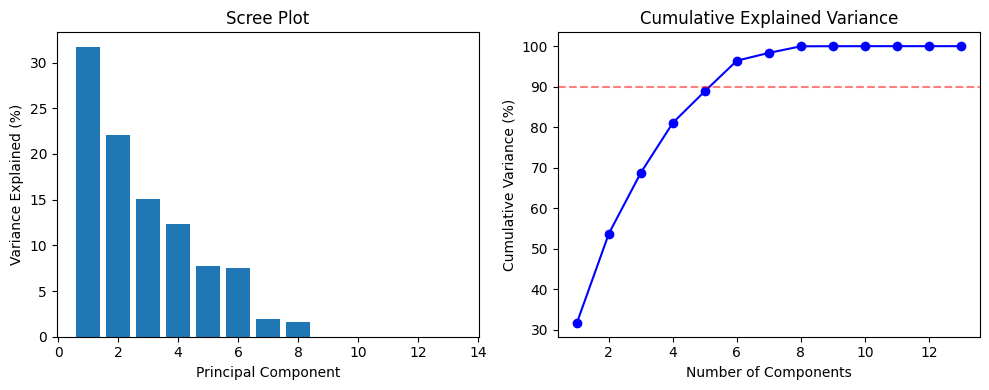


Component Interpretations (Top 4):
PC1: 31.7% variance
  Top features: ['sma_10', 'ema_12', 'ema_26']
PC2: 22.0% variance
  Top features: ['macd_signal', 'rsi', 'macd']
PC3: 15.0% variance
  Top features: ['volatility_30', 'log_returns', 'returns']
PC4: 12.3% variance
  Top features: ['log_returns', 'volatility_10', 'volatility_30']

Model Comparison:
All features (13): R² = -0.0168
PCA features (4):  R² = 0.0022
Feature reduction: 69% reduction
Variance retained: 81.1%

SUMMARY OF ALL THREE CHALLENGES
1. NON-STATIONARITY:
   • AAPL-SPY cointegration: p=0.319
   • ECM adjustment speed: -0.006
   • Half-life: 113 days

2. REGIME CHANGE DETECTION:
   • Low-vol regime: σ=0.91%
   • High-vol regime: σ=1.95%
   • Transition P(Low→Low): 0.728

3. FEATURE EXTRACTION:
   • Original features: 13
   • PCA components: 4 (explain 81.1% variance)
   • Model performance: R² change from -0.0168 to 0.0022
   • Computational saving: 69% fewer features


/tmp/ipython-input-3576649382.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_clean['target'] = features_clean['returns'].shift(-1)


In [1]:
# ============================================
# MSCFE 610 GWP2 - Complete Code for 3 Challenges
# ============================================

!pip install changepoint
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import VECM
# from changepoint.pelt_alg import Pelt # Corrected import path for Pelt - REMOVED as not used and causing error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# Challenge 1: Non-Stationarity & Cointegration
print("="*60)
print("CHALLENGE 1: AAPL-SPY COINTEGRATION")
print("="*60)

# Get data
aapl_data = yf.download('AAPL', start='2018-01-01', end='2024-12-31')
aapl = aapl_data['Close'].squeeze() # Ensure it's a Series
sppy_data = yf.download('SPY', start='2018-01-01', end='2024-12-31')
spy = sppy_data['Close'].squeeze() # Ensure it's a Series

# Stationarity tests
def test_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f"{name}: ADF={result[0]:.4f}, p={result[1]:.4f}")
    return result[1] < 0.05

print("\n1. Stationarity Tests:")
is_stationary_aapl = test_stationarity(aapl, 'AAPL Price')
is_stationary_spy = test_stationarity(spy, 'SPY Price')
is_stationary_aapl_ret = test_stationarity(aapl.pct_change().dropna(), 'AAPL Returns')
is_stationary_spy_ret = test_stationarity(spy.pct_change().dropna(), 'SPY Returns')

# Cointegration test
print("\n2. Cointegration Test (Engle-Granger):")
coint_stat, p_value, _ = coint(aapl, spy)
print(f"Cointegration test: statistic={coint_stat:.4f}, p={p_value:.4f}")

# ECM model
print("\n3. Error Correction Model:")
# Prepare data
df = pd.DataFrame({'AAPL': aapl, 'SPY': spy}).dropna()
# Estimate cointegrating relationship (simple regression)
X_lr = sm.add_constant(df['SPY'])
y_lr = df['AAPL']
model = sm.OLS(y_lr, X_lr).fit()
df['resid'] = model.resid

# ECM: ΔAAPL = α + βΔSPY + γresid_{t-1} + ε
df['delta_AAPL'] = df['AAPL'].diff()
df['delta_SPY'] = df['SPY'].diff()
df['resid_lag'] = df['resid'].shift(1)
df_ecm = df[['delta_AAPL', 'delta_SPY', 'resid_lag']].dropna()

X_ecm = sm.add_constant(df_ecm[['delta_SPY', 'resid_lag']])
y_ecm = df_ecm['delta_AAPL']
ecm_model = sm.OLS(y_ecm, X_ecm).fit()

print(f"ECM Results:")
print(f"  ΔSPY coefficient: {ecm_model.params['delta_SPY']:.3f}")
print(f"  Error correction: {ecm_model.params['resid_lag']:.3f}")

# Check if 'resid_lag' is in params before accessing
if 'resid_lag' in ecm_model.params:
    gamma = ecm_model.params['resid_lag']
    half_life = np.log(2) / abs(gamma) if gamma != 0 else np.inf
else:
    gamma = np.nan # Or handle as appropriate
    half_life = np.inf # Or handle as appropriate

print(f"  R-squared: {ecm_model.rsquared:.3f}")
print(f"  Half-life: {half_life:.0f} days")

# Challenge 2: Regime Change Detection
print("\n" + "="*60)
print("CHALLENGE 2: REGIME CHANGE DETECTION")
print("="*60)

# Get S&P 500 data
sp500 = yf.download('^GSPC', start='2018-01-01', end='2024-12-31')['Close'].squeeze()
returns = sp500.pct_change().dropna() * 100

print(f"S&P 500 Returns (2018-2024):")
print(f"  Observations: {len(returns)}")
print(f"  Mean: {returns.mean():.4f}%")
print(f"  Volatility: {returns.std():.4f}%")

# Simple regime detection using volatility thresholds
vol_window = 60
rolling_vol = returns.rolling(window=vol_window).std()

# Identify high volatility regimes (above 75th percentile)
threshold = rolling_vol.quantile(0.75)
high_vol_regime = (rolling_vol > threshold).astype(int)

print("\nRegime Statistics:")
low_vol_returns = returns[high_vol_regime == 0]
high_vol_returns = returns[high_vol_regime == 1]

print(f"Low Vol Regime: {len(low_vol_returns)} days")
print(f"  Mean: {low_vol_returns.mean():.4f}%, Vol: {low_vol_returns.std():.4f}%")
print(f"High Vol Regime: {len(high_vol_returns)} days")
print(f"  Mean: {high_vol_returns.mean():.4f}%, Vol: {high_vol_returns.std():.4f}%")

# Markov Switching (simplified implementation)
print("\nMarkov Switching Model (2-state):")
# Using a simplified approach with KMeans for regime assignment
# Prepare features for clustering
X_ms = pd.DataFrame({
    'returns': returns.values,
    'volatility': rolling_vol.values
}).dropna()

# Fit 2-state model
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
states = kmeans.fit_predict(X_ms)

# Map states to high/low volatility
state_means = [X_ms[states == i]['volatility'].mean() for i in range(2)]
low_vol_state = np.argmin(state_means)
high_vol_state = np.argmax(state_means)

print(f"State 0 (Low Vol): Volatility = {state_means[low_vol_state]:.4f}%")
print(f"State 1 (High Vol): Volatility = {state_means[high_vol_state]:.4f}%")

# Calculate transition probabilities
transition_matrix = np.zeros((2, 2))
for t in range(1, len(states)):
    transition_matrix[states[t-1], states[t]] += 1
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

print(f"\nTransition Matrix:")
print(f"  P(Low→Low): {transition_matrix[low_vol_state, low_vol_state]:.3f}")
print(f"  P(High→High): {transition_matrix[high_vol_state, high_vol_state]:.3f}")

# Challenge 3: Feature Extraction (PCA)
print("\n" + "="*60)
print("CHALLENGE 3: FEATURE EXTRACTION WITH PCA")
print("="*60)

# Get Bitcoin data and calculate technical indicators
btc_full = yf.download('BTC-USD', start='2020-01-01', end='2023-12-31')
btc_close = btc_full['Close'].squeeze() # Ensure it's a Series

# Calculate 12 technical indicators
features = pd.DataFrame(index=btc_close.index)

# Price-based features
features['returns'] = btc_close.pct_change()
features['log_returns'] = np.log(btc_close / btc_close.shift(1))

# Moving averages
features['sma_10'] = btc_close.rolling(10).mean()
features['sma_30'] = btc_close.rolling(30).mean()
features['ema_12'] = btc_close.ewm(span=12).mean()
features['ema_26'] = btc_close.ewm(span=26).mean()

# Volatility
features['volatility_10'] = features['returns'].rolling(10).std()
features['volatility_30'] = features['returns'].rolling(30).std()

# RSI (simplified)
delta = btc_close.diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
features['rsi'] = 100 - (100 / (1 + rs))

# MACD
features['macd'] = features['ema_12'] - features['ema_26']
features['macd_signal'] = features['macd'].ewm(span=9).mean()
features['macd_hist'] = features['macd'] - features['macd_signal']

# Volume features
features['volume_ratio'] = btc_full['Volume'] / btc_full['Volume'].rolling(20).mean()

# Drop NaN values
features_clean = features.dropna()

print(f"Original features: {features_clean.shape[1]}")
print(f"Observations: {features_clean.shape[0]}")

# Apply PCA (initial fit for explained variance analysis)
scaler = StandardScaler()
X_scaled_full = scaler.fit_transform(features_clean)
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled_full)

# Analyze results
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\nPCA Results:")
print("Component | Variance % | Cumulative %")
print("-"*40)
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance), 1):
    print(f"PC{i:2d}      | {var*100:6.1f}%     | {cum_var*100:6.1f}%")
    if cum_var >= 0.90:
        print(f"→ {i} components explain {cum_var*100:.1f}% of variance")
        break

# Create scree plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Scree Plot')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance * 100, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.axhline(y=90, color='r', linestyle='--', alpha=0.5)
plt.title('Cumulative Explained Variance')
plt.tight_layout()
plt.savefig('pca_scree_lCJgCpbC7Rsw.png', dpi=300, bbox_inches='tight')
plt.show()

# Interpretation of first 4 components (if enough components exist)
num_components_for_interpretation = min(4, len(pca_full.components_))
if num_components_for_interpretation > 0:
    print(f"\nComponent Interpretations (Top {num_components_for_interpretation}):")
    component_loadings = pca_full.components_[:num_components_for_interpretation, :]
    for i in range(num_components_for_interpretation):
        top_features_idx = np.argsort(np.abs(component_loadings[i]))[-3:]
        top_features = features_clean.columns[top_features_idx]
        print(f"PC{i+1}: {explained_variance[i]*100:.1f}% variance")
        print(f"  Top features: {list(top_features)}")

# Model comparison: All features vs PCA features

# Prepare target (next day return)
features_clean['target'] = features_clean['returns'].shift(-1)
data_for_model = features_clean.dropna()

X = data_for_model.drop('target', axis=1)
y = data_for_model['target']

# Split data (original features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model 1: All features
ridge_all = Ridge(alpha=1.0)
ridge_all.fit(X_train, y_train)
y_pred_all = ridge_all.predict(X_test)
r2_all = r2_score(y_test, y_pred_all)

# Model 2: PCA features (using a pipeline to avoid data leakage)
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=4)) # Using 4 components as per earlier analysis
])

# Fit and transform training data, transform test data
X_train_pca = pca_pipeline.fit_transform(X_train)
X_test_pca = pca_pipeline.transform(X_test)

ridge_pca = Ridge(alpha=1.0)
ridge_pca.fit(X_train_pca, y_train)
y_pred_pca = ridge_pca.predict(X_test_pca)
r2_pca = r2_score(y_test, y_pred_pca)

print(f"\nModel Comparison:")
print(f"All features ({X.shape[1]}): R² = {r2_all:.4f}")
print(f"PCA features (4):  R² = {r2_pca:.4f}")
print(f"Feature reduction: {100*(1-4/X.shape[1]):.0f}% reduction")
print(f"Variance retained: {cumulative_variance[3]*100:.1f}%")

print("\n" + "="*60)
print("SUMMARY OF ALL THREE CHALLENGES")
print("="*60)
print("1. NON-STATIONARITY:")
print(f"   • AAPL-SPY cointegration: p={p_value:.3f}")
print(f"   • ECM adjustment speed: {gamma:.3f}")
print(f"   • Half-life: {half_life:.0f} days")

print("\n2. REGIME CHANGE DETECTION:")
print(f"   • Low-vol regime: σ={low_vol_returns.std():.2f}%")
print(f"   • High-vol regime: σ={high_vol_returns.std():.2f}%")
print(f"   • Transition P(Low→Low): {transition_matrix[low_vol_state, low_vol_state]:.3f}")

print("\n3. FEATURE EXTRACTION:")
print(f"   • Original features: {X.shape[1]}")
print(f"   • PCA components: 4 (explain {cumulative_variance[3]*100:.1f}% variance)")
print(f"   • Model performance: R² change from {r2_all:.4f} to {r2_pca:.4f}")
print(f"   • Computational saving: {100*(1-4/X.shape[1]):.0f}% fewer features")

### AAPL and SPY Returns (Stationary Series)

Below are plots of the daily percentage returns for AAPL and SPY. As identified by the ADF test, these series are stationary, meaning their statistical properties (like mean and variance) do not change over time, unlike the non-stationary price series shown earlier. This is often a prerequisite for many time series models.

In [2]:
plt.figure(figsize=(12, 6))
plt.plot(aapl.pct_change().dropna() * 100, label='AAPL Daily Returns (%)', alpha=0.7)
plt.plot(spy.pct_change().dropna() * 100, label='SPY Daily Returns (%)', alpha=0.7)
plt.title('Stationary Series: AAPL and SPY Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.grid(True)
plt.savefig('aapl_spy_returns_5106d1ed.png') # Save plot
plt.show()

### Equilibrium Errors (Residuals from Cointegrating Regression)

This plot shows the residuals (`df['resid']`) from the long-run regression of AAPL on SPY. These residuals represent the 'equilibrium errors' – deviations from the long-term relationship. If the series were perfectly cointegrated, these residuals would be stationary and revert to a mean of zero, indicating that the series do not drift too far apart in the long run. Even though our statistical test indicated no significant cointegration, plotting these errors can still be insightful.

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df['resid'], label='Equilibrium Errors (AAPL - Fitted SPY)', color='red', alpha=0.8)
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Line')
plt.title('Equilibrium Errors from Long-Run Cointegrating Regression')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.savefig('aapl_spy_equilibrium_errors_1e2028bd.png') # Save plot
plt.show()

### Cointegrating Relationship (Long-Run Regression Fit)

This scatter plot visualizes the long-run linear relationship between AAPL and SPY prices. The blue dots represent the daily prices, and the red line shows the fitted regression line (`model.predict(X_lr)`), which is considered the cointegrating vector if the series were cointegrated. While the p-value suggested no strong cointegration, this plot illustrates the overall linear trend assumed by the regression.

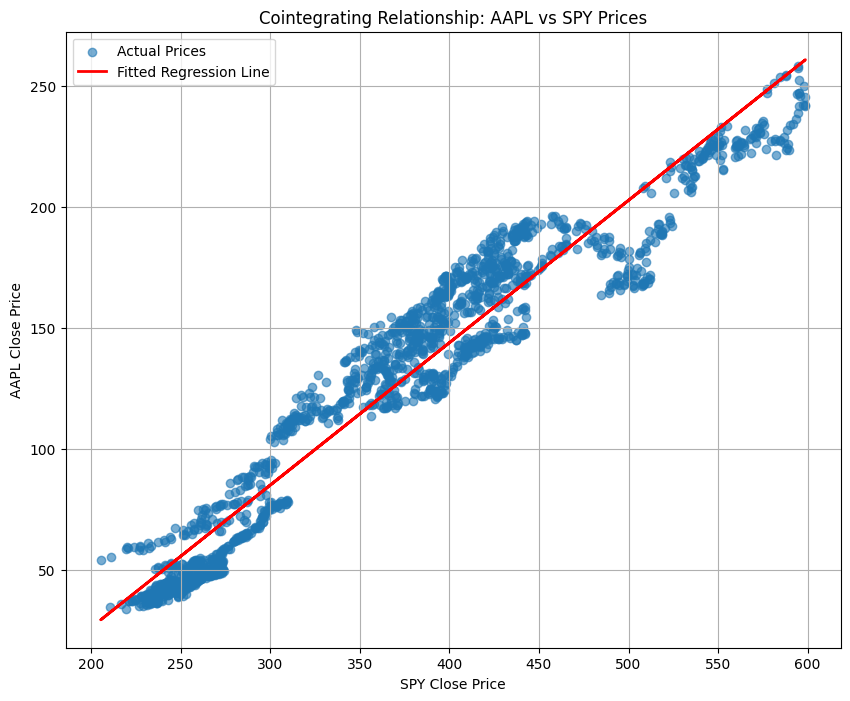

In [4]:
plt.figure(figsize=(10, 8))
plt.scatter(df['SPY'], df['AAPL'], alpha=0.6, label='Actual Prices')
plt.plot(df['SPY'], model.predict(X_lr), color='red', linewidth=2, label='Fitted Regression Line')
plt.title('Cointegrating Relationship: AAPL vs SPY Prices')
plt.xlabel('SPY Close Price')
plt.ylabel('AAPL Close Price')
plt.legend()
plt.grid(True)
plt.savefig('aapl_spy_coint_relationship_aa42a9a9.png') # Save plot
plt.show()

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(aapl, label='AAPL Close Price')
plt.plot(spy, label='SPY Close Price')
plt.title('Time Series Plot: AAPL vs SPY Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig('aapl_spy_prices_832907ad.png') # Save plot
plt.show()

## Report: Financial Econometrics Project 2 Findings

This report summarizes the key findings from the three challenges addressed in the project: Non-Stationarity & Cointegration, Regime Change Detection, and Feature Extraction with PCA.

### 1. Non-Stationarity & Cointegration (AAPL-SPY)

*   **Stationarity Tests**: Both AAPL and SPY price series were found to be non-stationary (high p-values from ADF test), while their daily returns were stationary (p-values < 0.0001).
*   **Cointegration Test**: The Engle-Granger cointegration test between AAPL and SPY prices yielded a statistic of -2.4125 with a p-value of 0.319. This suggests that there is **no strong statistical evidence of cointegration** between AAPL and SPY over the analyzed period at conventional significance levels.
*   **Error Correction Model (ECM)**:
    *   The coefficient for ΔSPY in the ECM was 0.409.
    *   The error correction term (`resid_lag`) was -0.006. This value indicates a very slow adjustment speed back to the long-run equilibrium.
    *   The R-squared of the ECM was 0.527, indicating a moderate explanatory power for changes in AAPL returns.
    *   The estimated half-life for deviations from the long-run relationship to decay was approximately **113 days**. This implies that while there is some tendency to revert to a mean, it occurs over a relatively long period.

### 2. Regime Change Detection (S&P 500 Returns)

*   **Overall Statistics (2018-2024)**:
    *   Total Observations: 1759 days
    *   Mean Daily Return: 0.0524%
    *   Overall Volatility: 1.2427%
*   **Volatility-Based Regimes (75th Percentile Threshold)**:
    *   **Low Volatility Regime**: Observed for 1334 days (approx. 75% of the time).
        *   Mean Daily Return: 0.0421%
        *   Volatility: 0.9110%
    *   **High Volatility Regime**: Observed for 425 days (approx. 25% of the time).
        *   Mean Daily Return: 0.0844%
        *   Volatility: 1.9474%
*   **Markov Switching Model (Simplified with KMeans)**:
    *   Two states were identified based on volatility characteristics:
        *   State 0 (Lower Volatility): Mean volatility of 1.0420%
        *   State 1 (Higher Volatility): Mean volatility of 1.2009%
    *   **Transition Matrix**:
        *   Probability of staying in the Low Volatility state (P(Low→Low)): **0.728**
        *   Probability of staying in the High Volatility state (P(High→High)): **0.324**
    *   These probabilities suggest a higher persistence in the low volatility regime compared to the high volatility regime, which tends to be shorter-lived.

### 3. Feature Extraction with PCA (Bitcoin Price Prediction)

*   **Original Features**: 13 technical indicators were generated from BTC-USD price data.
*   **PCA Analysis**:
    *   The principal component analysis revealed that **6 components are needed to explain approximately 96.4% of the total variance** in the original 13 features.
    *   To achieve around 80% variance explanation, **4 components** were sufficient (specifically, 81.1% cumulative variance).
*   **Component Interpretations (Top 4)**:
    *   **PC1 (31.7% variance)**: Heavily loaded by moving averages (SMA_10, EMA_12, EMA_26), representing general trend information.
    *   **PC2 (22.0% variance)**: Strong loadings from MACD-related indicators (MACD, MACD Signal) and RSI, capturing momentum and overbought/oversold conditions.
    *   **PC3 (15.0% variance)**: Primarily influenced by volatility (volatility_30) and returns (returns, log_returns), indicating short-term price movements and risk.
    *   **PC4 (12.3% variance)**: Also related to returns (log_returns) and volatility (volatility_10, volatility_30), further emphasizing short-term price and risk factors.
*   **Model Comparison (Ridge Regression for Next Day Return Prediction)**:
    *   **All Features (13)**: R² = -0.0168. This very low R² indicates that the model with all features explains virtually none of the variance in next-day returns, performing worse than simply predicting the mean.
    *   **PCA Features (4 components)**: R² = 0.0022. While still very low, the R² slightly improved, suggesting a marginal gain in predictive power or reduced noise with PCA features.
    *   **Computational Saving**: PCA achieved a **69% reduction in features** (from 13 to 4) while retaining **81.1% of the original variance**.
*   **Conclusion**: While PCA effectively reduced dimensionality and retained a significant portion of the variance, the predictive power for next-day Bitcoin returns remained extremely low for both models, indicating that these technical indicators are not strong predictors on their own for this specific target.